In [1]:
import pandas as pd
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

EDA

In [2]:
def display_scrollable_df(df, max_rows=5, height=300):
    display(HTML(df.head(max_rows).to_html(max_rows=max_rows, max_cols=100, escape=False)))
    display(HTML(f"""<style>
        .output_scroll {{
            max-height: {height}px;
            overflow-y: auto;
        }}
    </style>"""))

In [3]:
# Load Dataset - World Stock Prices (Daily Updating)
world_path = r"C:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\World Stock Prices (Daily Updating)\World-Stock-Prices-Dataset.csv"

world_df = pd.read_csv(world_path)

print("World Stock Prices Dataset:")
display_scrollable_df(world_df)

World Stock Prices Dataset:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-30 00:00:00-04:00,7.020000,7.240000,6.920000,7.100000,12750600.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-30 00:00:00-04:00,102.639999,102.940002,100.790001,102.000000,1505500.0,0.0,0.0,crocs,CROX,footwear,usa,NaN
2,2025-05-30 00:00:00-04:00,71.610001,72.470001,71.610001,72.099998,28013500.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
3,2025-05-30 00:00:00-04:00,125.080002,126.190002,123.750000,124.510002,82500.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
4,2025-05-30 00:00:00-04:00,294.970001,295.750000,291.630005,294.049988,5251700.0,0.0,0.0,american express,AXP,finance,usa,NaN


In [29]:
# Display basic information about the dataset
world_df.info()

# Display missing values per column
print("Missing values per column:")
print(world_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308386 entries, 0 to 308385
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   Date           308386 non-null  datetime64[ns, UTC]
 1   Open           308386 non-null  float64            
 2   High           308386 non-null  float64            
 3   Low            308386 non-null  float64            
 4   Close          308386 non-null  float64            
 5   Volume         308386 non-null  float64            
 6   Dividends      308386 non-null  float64            
 7   Stock Splits   308386 non-null  float64            
 8   Brand_Name     308386 non-null  object             
 9   Ticker         308386 non-null  object             
 10  Industry_Tag   308386 non-null  object             
 11  Country        308386 non-null  object             
 12  Capital Gains  2 non-null       float64            
dtypes: datetime64[ns, UTC](1), fl

In [30]:
# Display basic statistics of the dataset
world_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
count,308386.000000,308386.000000,308386.000000,308386.000000,3.083860e+05,308386.000000,308386.000000,2.0
mean,75.661412,76.526667,74.776843,75.672635,2.275673e+07,0.003630,0.000879,0.0
std,140.764878,142.296391,139.152683,140.758195,8.586249e+07,0.069773,0.115759,0.0
min,0.196890,0.199922,0.192798,0.198861,0.000000e+00,0.000000,0.000000,0.0
25%,15.873468,16.102672,15.663487,15.881960,1.376200e+06,0.000000,0.000000,0.0
50%,35.218640,35.636546,34.798152,35.216839,4.589031e+06,0.000000,0.000000,0.0
75%,83.050448,83.941272,82.174579,83.058233,1.213435e+07,0.000000,0.000000,0.0
max,3445.580078,3463.070068,3370.000000,3427.610107,7.421641e+09,15.000000,50.000000,0.0


In [31]:
# Display unique values in key columns
print("Unique tickers:", world_df['Ticker'].nunique())
print("Unique countries:", world_df['Country'].nunique())
print("Unique industries:", world_df['Industry_Tag'].nunique())

Unique tickers: 61
Unique countries: 7
Unique industries: 23


In [33]:
# Convert 'Date' column to datetime format and display the date range
world_df['Date'] = pd.to_datetime(world_df['Date'], utc=True)  
print("Date range:", world_df['Date'].min(), "to", world_df['Date'].max())

Date range: 2000-01-03 05:00:00+00:00 to 2025-05-30 04:00:00+00:00


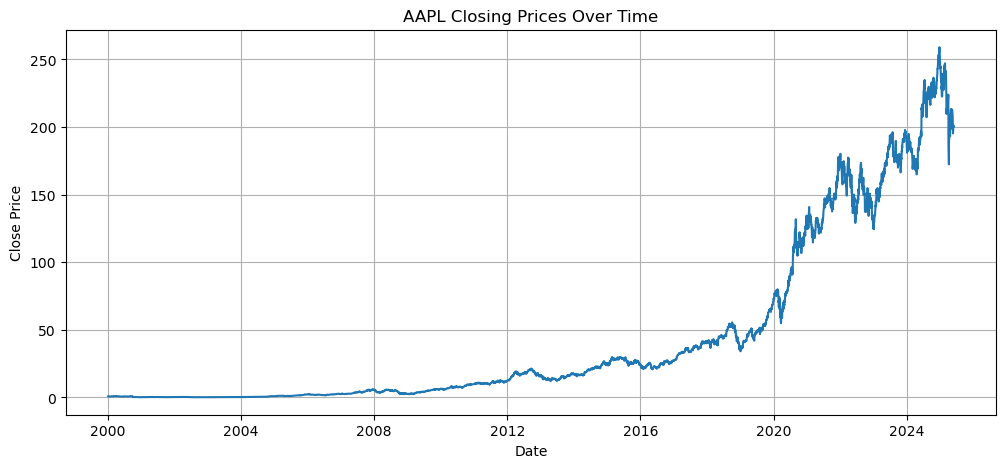

In [35]:
# Display closing prices for a sample ticker
sample_ticker = "AAPL"  # Change to a valid one in your dataset
world_df_sample = world_df[world_df['Ticker'] == sample_ticker]

plt.figure(figsize=(12, 5))
plt.plot(world_df_sample['Date'], world_df_sample['Close'])
plt.title(f"{sample_ticker} Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

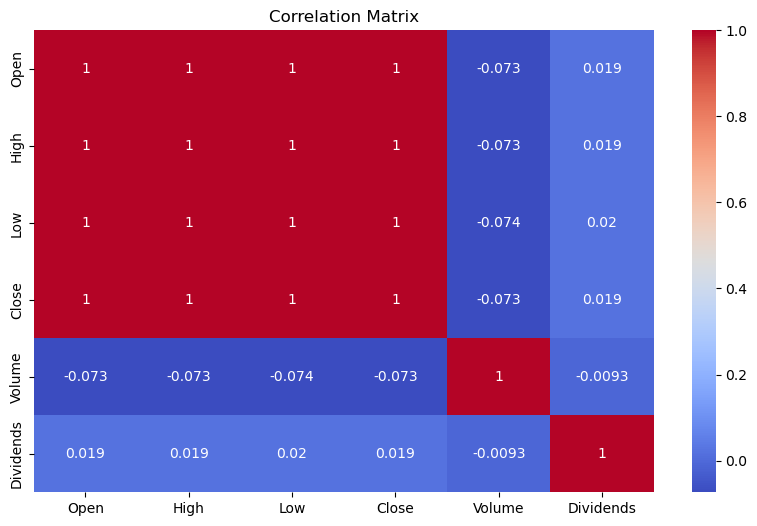

In [36]:
# Display heatmap of correlations between numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(world_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

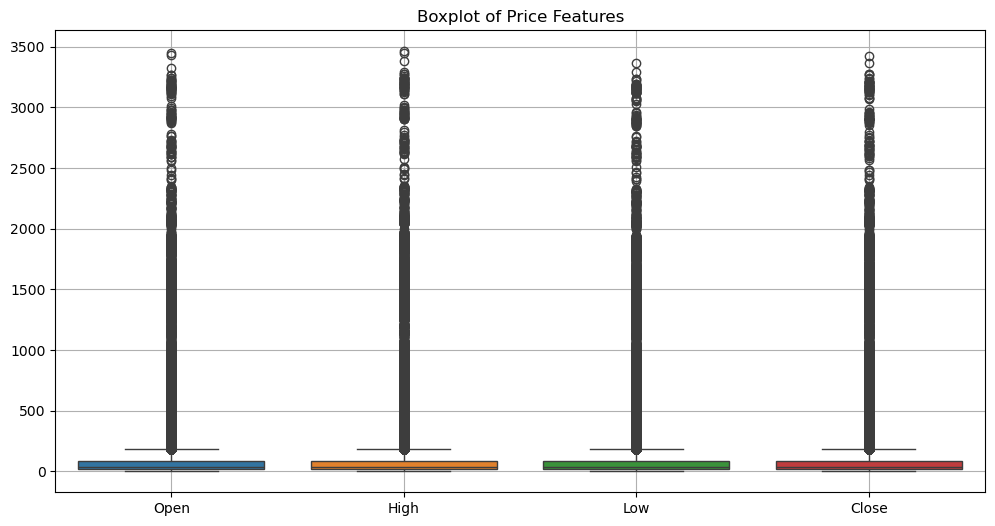

In [37]:
# Display boxplot of price features to identify outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=world_df[['Open', 'High', 'Low', 'Close']])
plt.title("Boxplot of Price Features")
plt.grid(True)
plt.show()

FEATURE SELECTION & FEATURE ENGINEERING

In [39]:
# Sort by Ticker and Date
world_df.sort_values(by=['Ticker', 'Date'], inplace=True)
world_df.reset_index(drop=True, inplace=True)

In [42]:
# Create a new column for previous day's closing price
world_df['Prev_Close'] = world_df.groupby('Ticker')['Close'].shift(1)

In [45]:
# Calculate daily returns as a percentage change from the previous day's close
world_df['Daily_Return'] = (world_df['Close'] - world_df['Prev_Close']) / world_df['Prev_Close'] * 100

In [46]:
# Calculate daily range as the difference between high and low prices
world_df['Daily_Range'] = world_df['High'] - world_df['Low']

In [47]:
# Calculate price change as the difference between close and open prices
world_df['Price_Change'] = world_df['Close'] - world_df['Open']

In [48]:
# Calculate moving averages for 7-day and 30-day periods
world_df['7_day_avg'] = world_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=7).mean())
world_df['30_day_avg'] = world_df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=30).mean())

In [ ]:
# Create additional time-based features
world_df['Day_of_Week'] = world_df['Date'].dt.dayofweek  
world_df['Month'] = world_df['Date'].dt.month  

In [50]:
# Select relevant features for modeling
y = world_df['Close']

In [51]:
# Select features for regression
features = [
    'Prev_Close', 'Daily_Return', 'Daily_Range', 
    'Price_Change', 'Volume', '7_day_avg', '30_day_avg', 
    'Day_of_Week', 'Month'
]

X = world_df[features]
y = world_df['Close']

MODEL TRAINING

In [57]:
# Combine X and y temporarily to drop rows with NaNs in any feature
model_data = pd.concat([X, y], axis=1)

# Drop rows with any NaN values
model_data.dropna(inplace=True)

# Re-separate features and target
X = model_data[features]
y = model_data['Close']

In [58]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  
)

In [59]:
# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [62]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression MAE:  {mae:.2f}")
print(f"Linear Regression RMSE: {rmse:.2f}")

Linear Regression MAE:  0.86
Linear Regression RMSE: 2.13


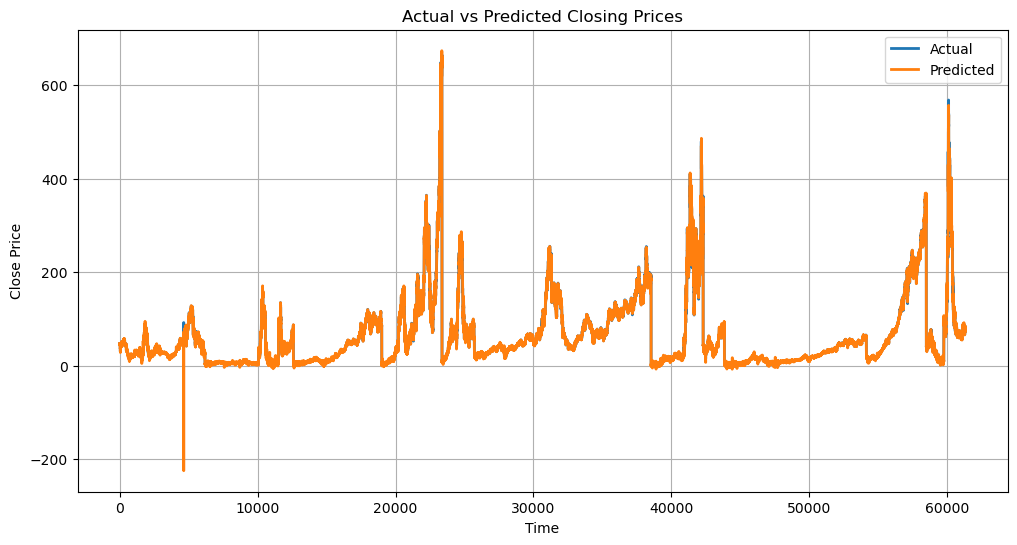

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

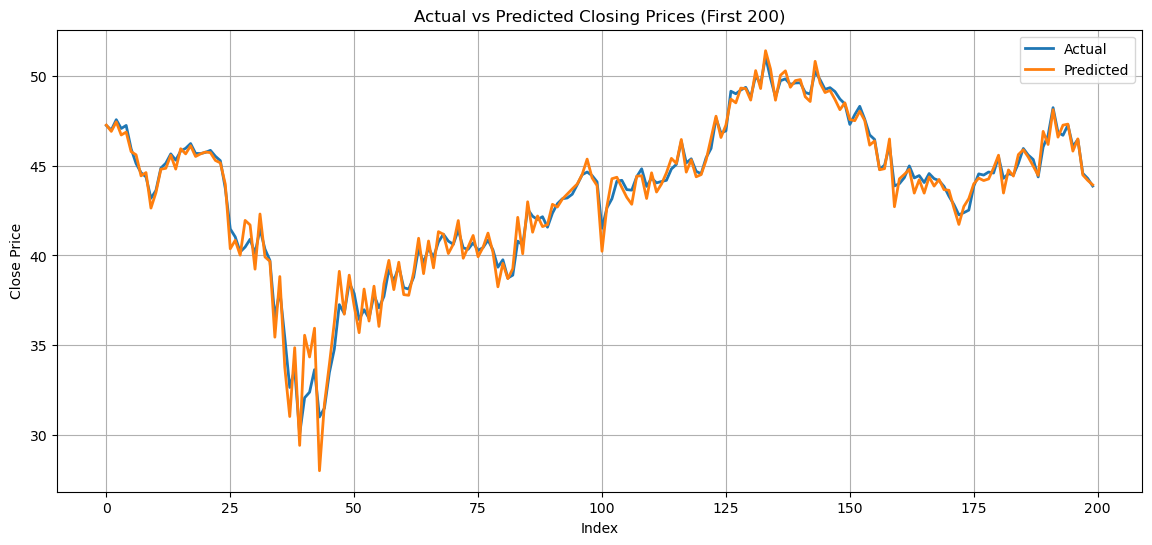

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label='Actual', linewidth=2)
plt.plot(y_pred[:200], label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Closing Prices (First 200)')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()